In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import transforms
import seaborn as sns
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import itertools

# Set seed for reproducibility
np.random.seed(215)



# Illustrative EM Example


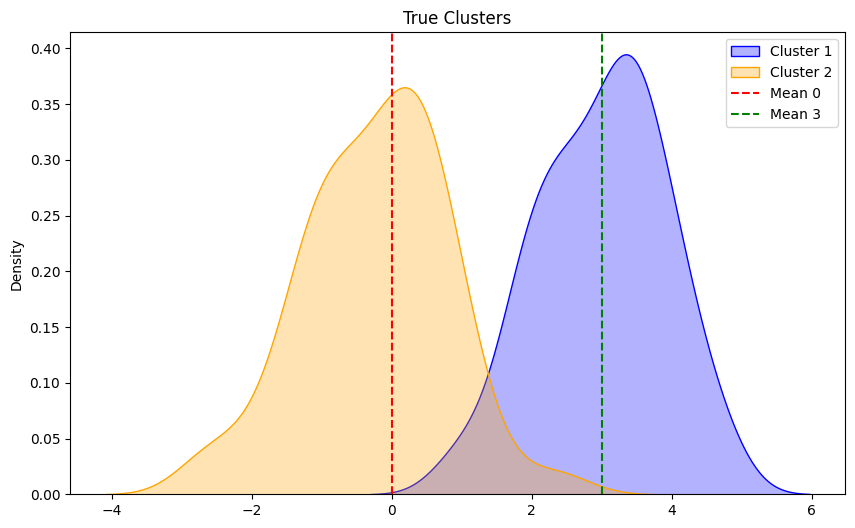

In [2]:

# Number of samples
n = 100

# Simulate cluster assignments from Bernoulli(0.5)
cluster_asgn = np.random.binomial(1, 0.5, n) + 1

# Simulate data from normal mixture model
x = np.empty(n)
means = [3, 0]
variances = [1, 1]
x[cluster_asgn == 1] = np.random.normal(loc=means[0], scale=variances[0], size=np.sum(cluster_asgn == 1))
x[cluster_asgn == 2] = np.random.normal(loc=means[1], scale=variances[1], size=np.sum(cluster_asgn == 2))

# Plot true clusters, with a KDE plot to visualize the distribution of data from the two clusters.
plt.figure(figsize=(10, 6))
sns.kdeplot(x[cluster_asgn == 1], fill=True, color='blue', alpha=0.3, label='Cluster 1')
sns.kdeplot(x[cluster_asgn == 2], fill=True, color='orange', alpha=0.3, label='Cluster 2')
plt.axvline(x=0, color='red', linestyle='--', label='Mean 0')
plt.axvline(x=3, color='green', linestyle='--', label='Mean 3')
plt.title("True Clusters")
plt.legend()
plt.show()

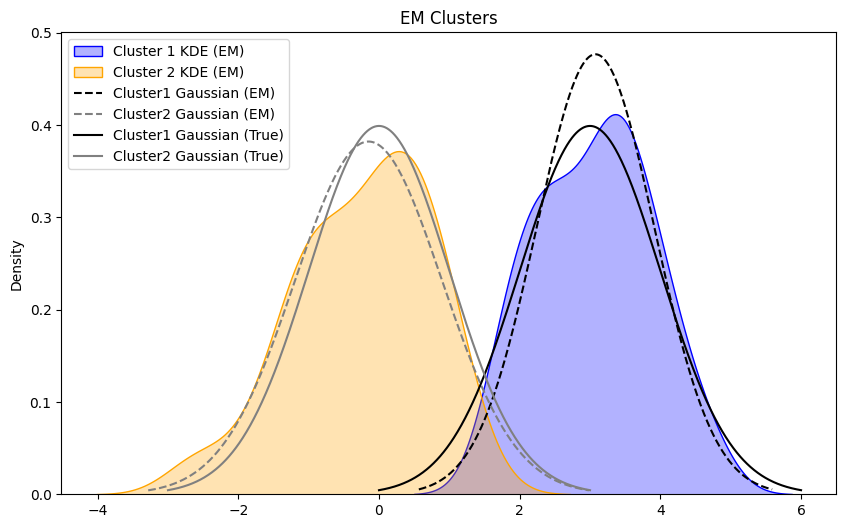

In [3]:

# Run EM using Gaussian Mixture
em_model = GaussianMixture(n_components=2, random_state=215)
em_model.fit(x.reshape(-1, 1))
em_out = em_model.predict(x.reshape(-1, 1))

# Plot clusters from EM
plt.figure(figsize=(10, 6))
sns.kdeplot(x[em_out == 0], fill=True, color='blue', alpha=0.3, label='Cluster 1 KDE (EM)')
sns.kdeplot(x[em_out == 1], fill=True, color='orange', alpha=0.3, label='Cluster 2 KDE (EM)')
colors = ['black', 'grey']
for i in range(2):
    mean = em_model.means_[i]
    variance = em_model.covariances_[i][0]
    x_axis = np.linspace(mean - 3 * np.sqrt(variance), mean + 3 * np.sqrt(variance), 1000)
    plt.plot(x_axis, norm.pdf(x_axis, mean, np.sqrt(variance)), color=colors[i], linestyle='--', label=f'Cluster{i+1} Gaussian (EM)')
for i in range(2):
    mean = means[i]
    variance = variances[i]
    x_axis = np.linspace(mean - 3 * np.sqrt(variance), mean + 3 * np.sqrt(variance), 1000)
    plt.plot(x_axis, norm.pdf(x_axis, mean, np.sqrt(variance)), color=colors[i], label=f'Cluster{i+1} Gaussian (True)')
plt.title("EM Clusters")
plt.legend()
plt.show()


In [4]:
# Number of misclassified examples
misclassified = np.sum(cluster_asgn != em_out + 1)
print("Number of misclassified examples:", misclassified)
print("Misclassification rate:", misclassified / n)

Number of misclassified examples: 3
Misclassification rate: 0.03


In [5]:
# 2D Illustrative EM Example

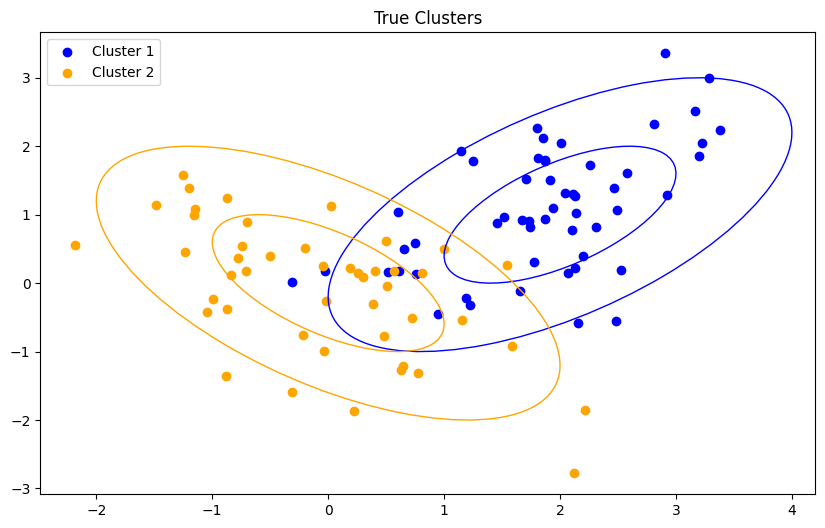

In [6]:
# Number of samples
n = 100

# Simulate cluster assignments from Bernoulli(0.5)
cluster_asgn = np.random.binomial(1, 0.5, n) + 1

# Simulate data from normal mixture model
x = np.empty((n, 2))
mean1 = [2, 1]
cov1 = np.array([[1, 0.6], [0.6, 1]])
x[cluster_asgn == 1] = np.random.multivariate_normal(mean=mean1, cov=cov1, size=np.sum(cluster_asgn == 1))
mean2 = [0, 0]
cov2 = np.array([[1, -0.6], [-0.6, 1]])
x[cluster_asgn == 2] = np.random.multivariate_normal(mean=mean2, cov=cov2, size=np.sum(cluster_asgn == 2))

def plot_ellipses(means, covs, ax):
    # code borrowed heavily from https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
    for i, (mean, cov) in enumerate(zip(means, covs)):
        for j, n_std in enumerate([1, 2]):
            pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])

            ell_radius_x = np.sqrt(1 + pearson)
            ell_radius_y = np.sqrt(1 - pearson)
            ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                              facecolor='none', edgecolor=['blue', 'orange'][i])

            scale_x = np.sqrt(cov[0, 0]) * n_std
            scale_y = np.sqrt(cov[1, 1]) * n_std

            transf = transforms.Affine2D() \
                .rotate_deg(45) \
                .scale(scale_x, scale_y) \
                .translate(mean[0], mean[1])

            ellipse.set_transform(transf + ax.transData)
            ax.add_patch(ellipse)

# Plot true clusters
plt.figure(figsize=(10, 6))
plt.scatter(x[cluster_asgn == 1, 0], x[cluster_asgn == 1, 1], color='blue', label='Cluster 1')
plt.scatter(x[cluster_asgn == 2, 0], x[cluster_asgn == 2, 1], color='orange', label='Cluster 2')
plot_ellipses([mean1, mean2], [cov1, cov2], plt.gca())
plt.title("True Clusters")
plt.legend()
plt.show()

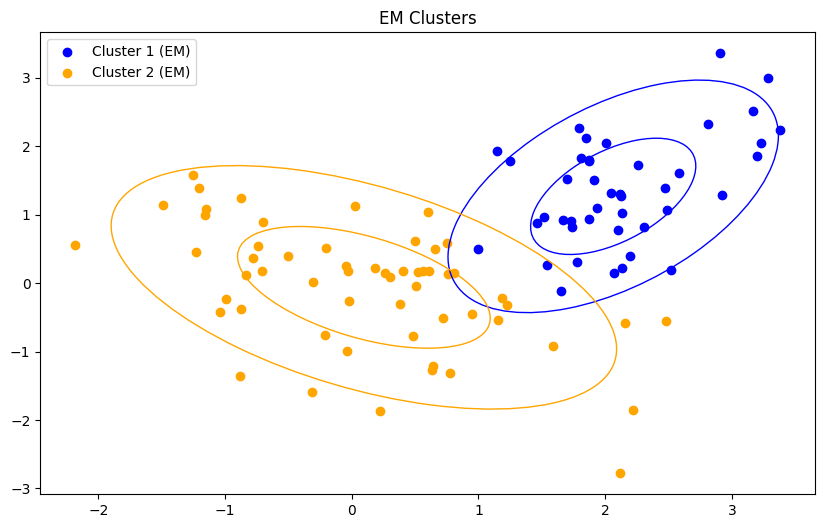

In [7]:
# Run EM
em_model_2d = GaussianMixture(n_components=2, random_state=215)
em_model_2d.fit(x)
em_out_2d = em_model_2d.predict(x)

# Plot clusters from EM, with ellipses showing their 1sd contours
plt.figure(figsize=(10, 6))
plt.scatter(x[em_out_2d == 0, 0], x[em_out_2d == 0, 1], color='blue', label='Cluster 1 (EM)')
plt.scatter(x[em_out_2d == 1, 0], x[em_out_2d == 1, 1], color='orange', label='Cluster 2 (EM)')

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
ax = plt.gca()
# Plot ellipses
means = em_model_2d.means_
covs = em_model_2d.covariances_

plot_ellipses(means, covs, ax)

plt.title("EM Clusters")
plt.legend()
plt.show()

In [8]:

# Number of misclassified examples
misclassified_2d = np.sum(cluster_asgn != em_out_2d + 1)
print("Number of misclassified examples:", misclassified_2d)
print("Misclassification rate:", misclassified_2d / n)

Number of misclassified examples: 15
Misclassification rate: 0.15


# Misspecified Model EM Example

What happens when the original data does not arise from normal mixture model? Does EM clustering break down? Try simulating data from a non-normal mixture model.


# Implementing EM algorithm
For a normal mixture model with two components, try implementing the EM algorithm from scratch by iterating between the E and M steps, for which we derived formulas in class.